## LeafScans WorkBook 4 - CNN
 * Previously adjusted LeafScan code to output 240x240 ndvi heatmaps as tensors for use by CNN. 
 * Similarly tensor-ized(?) N target values.
 * Define Dataset Loader class to read tensors from Test or Train sets
 * Define CNN class with parameters chosen from mild tuning (not shown)
 * Write train-test loop to record scores

In [1]:
import torch
# Pytorch utils for neural net
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.functional as F

import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

In [2]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [3]:
class HSI_Datset(Dataset):
    #init func tells us to supply x and y with invokation
    def __init__(self, set, target):
        self.dir_str = r'C:\Users\bdub\OneDrive - Michigan State University\LeafScans\Nutrient Scans\Data\DataTensors'
        self.set = set
        self.target = target
        self.scans = os.listdir(self.dir_str + r'\\' + self.set + r'\\Scans')
        self.nutes = os.listdir(self.dir_str + r'\\' + self.set + r'\\' + self.target)


    #Override some base methods from Dataset
    def __getitem__(self, index):
        scan = self.scans[index]
        fname = scan.split('-')
        uid = fname[1]
        trunk = fname[1] + '-' + fname[2]
        x = torch.load(self.dir_str + r'\\' + self.set + r'\\Scans\\' + scan).unsqueeze(0)
        x = torch.nan_to_num(x)
        ypath = self.dir_str + r'\\' + self.set + r'\\' + self.target
        y = torch.load(ypath +r'\\' + self.target + '-' + trunk)
        return x, y
    
    def __len__(self):
        return len(self.scans)

In [4]:
train = HSI_Datset(set = 'Train_Hybrid', target = 'N')
train_loader = DataLoader(train, batch_size=476, shuffle=True)
test = HSI_Datset(set = 'Test_Hybrid', target = 'N')
# 238/2 = 119
test_loader = DataLoader(test, batch_size=198, shuffle=True)
val_loader = DataLoader(test, batch_size = 396, shuffle = False)

In [5]:
class HSI_CNN(nn.Module):
    def __init__(self):
        super(HSI_CNN, self).__init__()
        # if padding = k -1 then input img == output convolved image
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels =3, kernel_size=3, padding = 2).double()
        self.avgpool1 = nn.AvgPool2d(kernel_size=3)
        self.cnn2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding = 2).double()
        self.avgpool2 = nn.AvgPool2d(kernel_size=3)
        #self.cnn3 = nn.Conv2d(in_channels=5, out_channels=8, kernel_size=3, padding = 2).double()
        #self.maxpool3 = nn.MaxPool2d(kernel_size=3)
        # need to do math to calculate final input size for linear
        self.linear1 = torch.nn.Linear(3380, 50).double()
        self.linear2 = torch.nn.Linear(50, 10).double()
        self.predict = torch.nn.Linear(10, 1).double()

    def forward(self, x):
        x = self.cnn1(x)
        x = F.relu(x)
        x = self.avgpool1(x)
        x = self.cnn2(x)
        x = F.relu(x)
        x = self.avgpool2(x)
        #x = self.cnn3(x)
        #x = F.relu(x)
        #x = self.maxpool3(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.predict(x).squeeze(0)
        return x

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Running on NDVI
* switching to L1Loss seems to have positive effect. L1 generally more robust to outliers than MSE
* Plug in values to proposal and submit

In [7]:

nute_net = HSI_CNN().cuda()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(nute_net.parameters(), lr = 0.001)

In [8]:
from sklearn.metrics import r2_score

e = 300
train_mse = []
train_r2 = []
test_mse = []
test_r2 = []

for epoch in range(e):
    for data in train_loader:
        train_mse_batch = []
        y = data[1].unsqueeze(1).to(device)
        x = data[0].to(device)
        outputs = nute_net(x)
        loss = criterion(y, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('MSE', loss.item())
        r2 = r2_loss(outputs, y).item()
        print(r2)
        #r2_2 = r2_score(y.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        #print(r2_2)
        train_mse.append(loss.item())
        train_r2.append(r2)
    for data in test_loader:  
        with torch.no_grad():
            y_test = data[1].unsqueeze(1).to(device)
            x = data[0].to(device).to(device)
            predictions = nute_net(x)
            test_loss = criterion(y_test, predictions)
            r2 = r2_loss(predictions, y_test).item()
            test_r2.append(r2)
            print('Test r2: ', r2)
            test_mse.append(test_loss.item())
            #print('Val R2:', r2score(predictions, y))
    print(epoch)
    #print('Val R2:', r2score(predictions, y))

-48.51591502481928
-44.92648425099438
Test r2:  -43.104195627368895
Test r2:  -30.450724858661562
0
-42.596961942759286
-39.87408680310777
Test r2:  -27.321085756594428
Test r2:  -33.55907115757501
1
-36.53416313118321
-31.390870509533862
Test r2:  -21.521068864377906
Test r2:  -23.58875651098768
2
-28.31850795789377
-21.585159638261608
Test r2:  -12.671146600285836
Test r2:  -16.1946812705514
3
-18.17448840361525
-11.768050626504845
Test r2:  -6.043403350883658
Test r2:  -6.057427302956943
4
-7.746118376636256
-3.756134554425535
Test r2:  -0.7949133899322329
Test r2:  -0.49606422221279245
5
-1.0120705033387192
-0.8740047061918987
Test r2:  -1.7867919288206235
Test r2:  -2.356196986658442
6
-2.79332905669967
-4.349045223682962
Test r2:  -4.0393094944038355
Test r2:  -4.921548673866296
7
-5.650619540728123
-4.342203729953417
Test r2:  -2.3150943819186898
Test r2:  -3.049956726185516
8
-3.045574913488813
-2.043039165017915
Test r2:  -0.4765349982469409
Test r2:  -0.5995469153024653
9
-0.

0.46697028641249105
0.4592749901825791
Avg of last 4 batches(2 full epochs)
0.3327752480121855
Avg of first 4 batches(2 full epochs)
-33.608769350049975


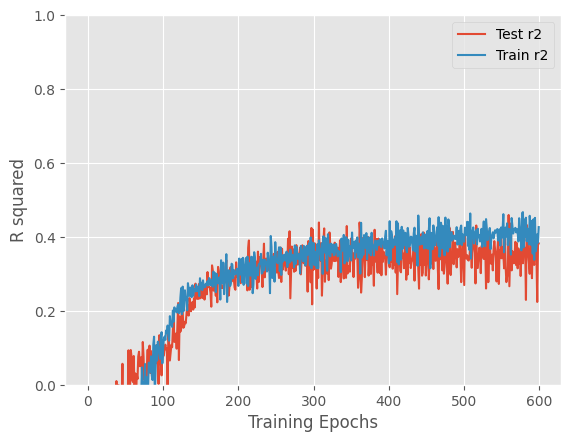

In [12]:
print(max(train_r2))
print(max(test_r2))
print('Avg of last 4 batches(2 full epochs)')
print(np.array(test_r2[-4:]).mean())
print('Avg of first 4 batches(2 full epochs)')
print(np.array(test_r2[:4]).mean())
with plt.style.context(('ggplot')):
    plt.plot(test_r2[:], label='Test r2')
    plt.xlabel('Training Epochs')
    plt.ylabel('R squared')
    plt.plot(train_r2[:], label = 'Train r2')
    plt.ylim(0, 1)
    plt.legend()
    plt.show()

In [11]:
nute_net.parameters

<bound method Module.parameters of HSI_CNN(
  (cnn1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (avgpool1): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (cnn2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (avgpool2): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (linear1): Linear(in_features=3380, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)>

In [12]:
[print(p) for p in nute_net.parameters() if p.requires_grad]

Parameter containing:
tensor([[[[-0.1270,  0.3127,  0.2673],
          [-0.1464,  0.2144, -0.2784],
          [-0.0106, -0.2193, -0.2224]]],


        [[[-0.1340, -0.2311,  0.3469],
          [ 0.3378,  0.3615, -0.0828],
          [-0.2823, -0.2704, -0.1819]]],


        [[[-0.0078,  0.0435, -0.0952],
          [-0.0948,  0.1243, -0.0650],
          [ 0.1104,  0.1014, -0.2495]]]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([0.1821, 0.0983, 0.0694], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([[[[ 1.2608e-01, -1.0907e-01, -8.2671e-02],
          [ 2.2461e-02,  7.4764e-02,  4.2968e-02],
          [-1.9183e-01,  3.0003e-03,  1.2247e-01]],

         [[ 4.5307e-02,  8.7052e-02,  1.6582e-01],
          [-2.5653e-03,  9.4790e-02,  1.7423e-01],
          [-1.4585e-01,  6.1420e-02,  6.8386e-02]],

         [[-1.6519e-01,  6.7756e-03, -1.7755e-01],
          [ 1.1299e-01, -1.4146e-01,  1.0271e-01

[None, None, None, None, None, None, None, None, None, None]

In [13]:
# calculate total trainable parameters for nute_net
tparams = sum(p.numel() for p in nute_net.parameters() if p.requires_grad)
print(tparams)

169741


[[3.01301064]
 [3.41227641]
 [3.34731083]
 [3.37962349]
 [3.03371011]
 [3.19552414]
 [2.89208767]
 [2.93698735]
 [3.21825025]
 [3.07487721]
 [2.98677313]
 [3.10025539]
 [3.10112942]
 [2.6393376 ]
 [3.27484797]]
[[3.36]
 [3.36]
 [3.36]
 [3.36]
 [2.96]
 [2.96]
 [2.96]
 [2.96]
 [2.96]
 [2.95]
 [2.95]
 [2.95]
 [2.95]
 [3.49]
 [3.49]]


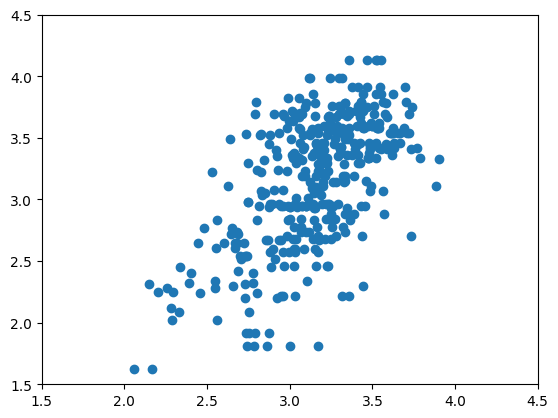

In [14]:
# make a graph of predictions from nute_net
for data in val_loader:  
        with torch.no_grad():
            y_test = data[1].unsqueeze(1)
            x = data[0].to(device)
            predictions = nute_net(x).cpu().detach().numpy()
            y_test = y_test.detach().numpy()
            print(predictions[:15])
            print(y_test[:15])
plt.scatter(x= predictions, y = y_test)
plt.ylim(1.5, 4.5)
plt.xlim(1.5, 4.5)
plt.show()